# Analysis and Visualization of Complex Agro-Environmental Data
---
### Exercise #6 - correction

In [1]:
import pandas as pd
import zipfile
import seaborn as sns # For plotting
import matplotlib.pyplot as plt # For showing plots
import numpy as np # for getting our distribution
import seaborn as sns # for plotting
from scipy import stats # to compute statistics
import statsmodels.api as sm



In [12]:
df = pd.read_csv('EFIplus_medit.zip',compression='zip', sep=";")
df = df.dropna() # remove all rows with missing data

#### 6.1. Create a column with the total number of species present (species richness) in each sampling site.

In [ ]:
# check the name of the first column of species names in the names list:
list(df)

In [ ]:
# Now check the index of the first species column
df.columns.get_loc("Abramis brama")

In [ ]:
# The species columns goes from 56 to the last column - extract the name of the spceis columns
sp_pres = df.columns[56:]
sp_pres

In [15]:
# sum all the species presence/absence data into a new column named 'sp_rich'
df['sp_rich'] = df[sp_pres].sum(axis=1)

#### 6.2 Run a simple linear regression relating the species richness with each one of the continuous environmental variables in the dataset: Altitude, Actual_river_slope, Elevation_mean_catch, prec_ann_catch, temp_ann, temp_jan, temp_jul. Before running the analyses, check if any of the variables requires to be transformed and apply the appropriate transformation. Compute the regression coefficient estimates, the r-square and the F-statistics. You may plot the fitted model.

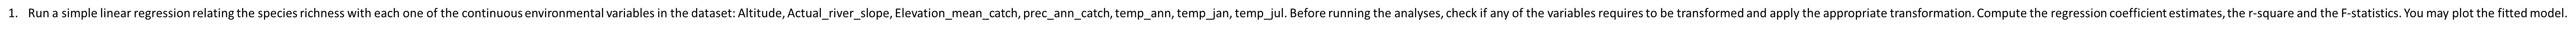

In [ ]:
# Subset the df by selecting the environmental variables and the species richness columns
df_rich_env = df[["sp_rich", "Altitude", "Actual_river_slope","Elevation_mean_catch", "prec_ann_catch","temp_ann","temp_jan","temp_jul"]]
df_rich_env

In [ ]:
# Plot histogram for each environmental variable (replace by variable name)
sns.histplot(data=df_rich_env[["temp_jul"]])

In [ ]:
# Better to transform "Actual_river_slope" (e.g. log(x+1) - need to add 1 because there are 0's) - RUN IT ONLY ONCE!!!
df_rich_env[['logActual_river_slope']] = np.log10(df_rich_env[['Actual_river_slope']]+1)
sns.histplot(data=df_rich_env[["logActual_river_slope"]])


In [ ]:
# Run regression for each environmental variable. import formula api as alias smf 
import statsmodels.formula.api as smf

# formula: response ~ predictor
model_alt = smf.ols(formula='sp_rich ~ Altitude', data=df_rich_env).fit().summary()
model_slope = smf.ols(formula='sp_rich ~ logActual_river_slope', data=df_rich_env).fit().summary()
model_elev = smf.ols(formula='sp_rich ~ Elevation_mean_catch', data=df_rich_env).fit().summary()
model_prec = smf.ols(formula='sp_rich ~ prec_ann_catch', data=df_rich_env).fit().summary()
model_temp = smf.ols(formula='sp_rich ~ temp_ann', data=df_rich_env).fit().summary()
model_tempjan = smf.ols(formula='sp_rich ~ temp_jan', data=df_rich_env).fit().summary()
model_tempjul = smf.ols(formula='sp_rich ~ temp_jul', data=df_rich_env).fit().summary()

print(model_alt)
print(model_slope)
print(model_elev)
print(model_prec)
print(model_temp)
print(model_tempjan)
print(model_tempjul)


In [ ]:
sns.lmplot(x='Altitude', y='sp_rich', data=df_rich_env)
sns.lmplot(x='Actual_river_slope', y='sp_rich', data=df_rich_env)
sns.lmplot(x='Elevation_mean_catch', y='sp_rich', data=df_rich_env)
sns.lmplot(x='prec_ann_catch', y='sp_rich', data=df_rich_env)
sns.lmplot(x='temp_ann', y='sp_rich', data=df_rich_env)
sns.lmplot(x='temp_jan', y='sp_rich', data=df_rich_env)

In [ ]:
# Alternative using a loop

import statsmodels.api as sm

explan_vars = ["Altitude", "logActual_river_slope","Elevation_mean_catch", "prec_ann_catch","temp_ann","temp_jan","temp_jul"]

# Loop
for Xi in explan_vars: # loop for each variable name
    # Extract the response and explanatory variables
    y = df_rich_env['sp_rich']
    X = df_rich_env[Xi]
    
    # Add a constant term to the explanatory variable (intercept term)
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Print the results
    print(results.summary())

#### 6.3 Now try to run a multiple linear regression with the same data and check the differences between the previous univariate regression coefficients and the new coefficients. Plot the partial dependence plots to compare responses with the previous single effects.


In [ ]:
# Multiple linear regression with the same data and check the differences between the previous univariate regression coefficients and new coefficients

y=df_rich_env["sp_rich"]
x=df_rich_env[["Altitude", "Actual_river_slope","Elevation_mean_catch", "prec_ann_catch","temp_ann","temp_jan","temp_jul"]]

x = sm.add_constant(x) # adding a constant (Intercept)

model = sm.OLS(y, x).fit()
predictions = model.predict(df_rich_env) 

print_model = model.summary()
print(print_model)

In [ ]:
# Get partial dependency plots (compare with the univariate plots above)
fig = plt.figure(figsize=(8, 10))
sm.graphics.plot_partregress_grid(model, fig=fig)
fig.tight_layout(pad=1.0)
plt.show()

#### 6.4 Check the multicolinearity among the predictor variables and run a second more parsimonious regression model. Check how the coefficients have changed.

In [ ]:
# Visualization of the correlation matrix

# Create plotting function
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

# Subset by selecting environmental variables only
df_env = df_rich_env[["Altitude", "Actual_river_slope","Elevation_mean_catch", "prec_ann_catch","temp_ann","temp_jan","temp_jul"]]

# Plot the matrix
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(df_env, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.histplot, kde_kws={'color': 'black'})
g.map_upper(corrdot);

In [ ]:
# Better to remove altitude, elevation of the upstream catchment and mean annual temperature from the model

y=df_rich_env["sp_rich"]
x=df_rich_env[["logActual_river_slope", "prec_ann_catch","temp_jan","temp_jul"]]

x = sm.add_constant(x) # adding a constant (Intercept)

model = sm.OLS(y, x).fit()

print_model = model.summary()
print(print_model)